In [70]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Masking,Bidirectional, LSTM, RepeatVector, Dense, TimeDistributed,MaxPooling1D, Flatten, Conv1D,Conv2D,Dropout, MaxPooling2D # for creating layers inside the Neural Network
from keras.optimizers import Adam , SGD
# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import numpy.ma as ma
# Sklearn
import sklearn
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.preprocessing import MinMaxScaler # for feature scaling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error # for calculating the cost function
from sklearn.ensemble import RandomForestRegressor # for building the model
# Visualization
import plotly 
import plotly.express as px
import plotly.graph_objects as go
print('plotly: %s' % plotly.__version__) # print version
from matplotlib import pyplot as plt

#file accessing
import os
# time stuff
from datetime import timedelta
import calendar


Tensorflow/Keras: 2.9.0
pandas: 1.4.2
numpy: 1.22.4
sklearn: 1.1.1
plotly: 5.9.0


In [71]:
#@title Define the plotting functions
def plot_the_model(trained_weight, trained_bias, feature, label):
  """Plot the trained model against the training feature and label."""

  # Label the axes.
  plt.xlabel("feature")
  plt.ylabel("label")

  # Plot the feature values vs. label values.
  plt.scatter(feature, label)

  # Create a red line representing the model. The red line starts
  # at coordinates (x0, y0) and ends at coordinates (x1, y1).
  x0 = 0
  y0 = trained_bias
  x1 = feature[-1]
  y1 = trained_bias + (trained_weight * x1)
  plt.plot([x0, x1], [y0, y1], c='r')

  # Render the scatter plot and the red line.
  plt.show()

def plot_the_loss_curve(epochs, rmse):
  """Plot the loss curve, which shows loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")
  #epochs.remove(max(epochs))
  
  #rmse.drop(max(rmse))
  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()

print("Defined the plot_the_model and plot_the_loss_curve functions.")

Defined the plot_the_model and plot_the_loss_curve functions.


##### Read from file and establish dataframe and future functions

In [72]:
df=pd.read_csv('InSAR_data_south/displacement/traintestset3.csv')
df=df.set_index([df.columns[0],df.columns[1]])
df.columns=pd.to_datetime(df.columns, format='%Y-%m-%d')
df=df.dropna(axis=0, how='all')#drop full nan rows

##### Remove next line to include all data

In [73]:
#df=df.iloc[500000:510000] #cuts data to long 120-119 approx
df

2014-11-08  2014-12-02  2014-12-26  2015-02-12  \
Longitude Latitude                                                   
-119.499  35.8811          0.0     -5.1976    0.002910    -0.87038   
-119.489  36.0692          0.0     -6.1830   -2.290800    -6.39680   
-119.485  35.9212          0.0     -5.4226   -0.099413    -0.40273   
-119.483  35.8892          0.0     -5.2906    0.279230    -0.61004   
          36.0872          0.0     -5.6696   -2.353800    -5.54400   
...                        ...         ...         ...         ...   
-119.203  35.9012          0.0     -2.1813    0.146740    -0.82776   
          36.0172          0.0     -1.7840   -0.788450    -2.57420   
-119.201  35.6711          0.0     -2.6897    1.140600     0.90695   
          35.7871          0.0     -1.7958    1.223100     0.80434   
          35.9852          0.0     -1.0605    0.267720    -1.71080   

                    2015-03-08  2015-04-01  2015-04-25  2015-05-19  \
Longitude Latitude                                                   
-119.499  35.8811     -2.83100    -0.17624    -2.49600     -2.5998   
-119.489  36.0692    -10.11400    -9.55530   -13.43600    -15.6880   
-119.485  35.9212     -3.26670    -0.75501    -3.53220     -4.0610   
-119.483  35.8892     -2.88080    -0.36279    -3.06800     -3.6082   
          36.0872     -9.14370    -8.62340   -11.66000    -13.6640   
...                        ...         ...         ...         ...   
-119.203  35.9012     -1.59590    -1.49870    -3.26190     -6.0670   
          36.0172     -3.52040    -3.68770    -4.21260     -6.5993   
-119.201  35.6711     -0.61151     0.80867    -0.32340     -2.2987   
          35.7871      0.31989     1.70730    -0.31014     -1.8259   
          35.9852     -2.86360    -3.68310    -4.51400     -7.3040   

                    2015-06-12  2015-07-06  ...  2018-10-18  2018-10-30  \
Longitude Latitude                          ...                           
-119.499  35.8811      -4.2793     -2.6121  ...    -17.6270    -17.6170   
-119.489  36.0692     -19.0580    -20.1470  ...    -78.8950    -79.7530   
-119.485  35.9212      -5.8979     -5.0366  ...    -31.0530    -30.7590   
-119.483  35.8892      -5.4421     -3.9762  ...    -23.4700    -23.4350   
          36.0872     -16.5320    -17.6760  ...    -67.3870    -68.5080   
...                        ...         ...  ...         ...         ...   
-119.203  35.9012      -8.1696    -10.1180  ...    -38.7620    -38.4330   
          36.0172      -7.5372     -8.5782  ...    -47.9900    -47.8310   
-119.201  35.6711      -1.2513     -1.8454  ...     -4.7416     -4.6556   
          35.7871      -1.9427     -2.3615  ...     -2.0354     -1.7464   
          35.9852      -6.9339     -9.2966  ...    -53.8070    -53.2410   

                    2018-11-11  2018-11-17  2018-11-23  2018-12-05  \
Longitude Latitude                                                   
-119.499  35.8811     -17.7090    -17.2970    -18.4290    -18.4740   
-119.489  36.0692     -80.0230    -79.5920    -81.3310    -80.0170   
-119.485  35.9212     -31.1280    -30.6970    -32.0480    -31.8140   
-119.483  35.8892     -23.5610    -23.1400    -24.2660    -24.3520   
          36.0872     -68.7930    -68.4550    -69.9330    -68.9950   
...                        ...         ...         ...         ...   
-119.203  35.9012     -38.3710    -38.2510    -38.7200    -37.9590   
          36.0172     -48.3430    -47.9480    -48.8440    -48.2160   
-119.201  35.6711      -4.0714     -3.9347     -4.4595     -4.7927   
          35.7871      -1.1589     -1.1395     -1.4032     -1.1742   
          35.9852     -52.9380    -52.6810    -53.5040    -52.6110   

                    2018-12-17  2018-12-29  2019-01-10  2019-01-22  
Longitude Latitude                                                  
-119.499  35.8811    -16.76100    -17.3360   -18.36200    -18.0470  
-119.489  36.0692    -79.62900    -80.7130   -81.28900    -80.7730  
-119.485  35.9212    -30.57200    -

# Timestep

In [74]:
timestep=10

# Shaping function (remove start and step for first for loop to include all data)

In [75]:
def shaping(datain, timestep):
    #print(arr)
    cnt=0
    for row in range(len(datain.index)): #picks a row at every iteration, allows to reduction of input and inclusion of multiple time series, remove start and step to run on full dataset 
    # Convert input dataframe to array and flatten
        #datain.iloc[row].fillna(datain.iloc[row].mean).to_numpy().flatten()
        arr=datain.iloc[row].interpolate().to_numpy().flatten() # flatten row
        #arr=arr.fillna(arr.mean)
        #arr=np.where(np.isnan(arr), ma.array(arr, mask=np.isnan(arr)).mean(), arr) 
        for mth in range(0, len(datain.columns)-(2*timestep)+1): # Define range lenght of the dates - 2* amount of timesep?? +1
            cnt=cnt+1 # Gives us the number of samples. Later used to reshape the data
            X_start=mth # Start month for inputs of each sample
            X_end=mth+timestep # End month for inputs of each sample
            Y_start=mth+timestep # Start month for targets of each sample. Note, start is inclusive and end is exclusive, that's why X_end and Y_start is the same number
            Y_end=mth+2*timestep # End month for targets of each sample.  
            
            # Assemble input and target arrays containing all samples
            if cnt==1:
                X_comb=arr[X_start:X_end]
                Y_comb=arr[Y_start:Y_end]
            else: 
                X_comb=np.append(X_comb, arr[X_start:X_end])
                Y_comb=np.append(Y_comb, arr[Y_start:Y_end])
    # Reshape input and target arrays
    X_out=np.reshape(X_comb, (cnt, timestep, 1))
    Y_out=np.reshape(Y_comb, (cnt, timestep, 1))
    return X_out, Y_out

##### Step 2 - Split and Shape data

In [76]:
test=pd.read_csv('InSAR_data_south/displacement/testset3.csv')
test=test.set_index([test.columns[0],test.columns[1]])
test.columns=pd.to_datetime(test.columns, format='%Y-%m-%d')
test=test.dropna(axis=0, how='all')#drop full nan rows
#train, test = train_test_split(df, test_size=0.2)
# creates sequences to train
#Need to decide on how to deal with rows with nans in them
X_train , Y_train = shaping(datain=df, timestep= timestep )
X_test, Y_test=shaping(test,10)
print(Y_test.shape)

nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))
nsamples, nx, ny = Y_train.shape
Y_train = Y_train.reshape((nsamples,nx*ny))
nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))
nsamples, nx, ny = Y_test.shape
Y_test = Y_test.reshape((nsamples,nx*ny))
print(Y_test.shape)

(17290, 10, 1)
(17290, 10)


##### Step 3 - Specify the structure of a Neural Network, first model

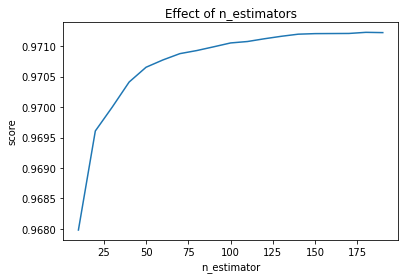

In [77]:
# set model
model = RandomForestRegressor(n_jobs = -1, random_state = 64)
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, Y_train)
    scores.append(model.score(X_test, Y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)



In [78]:
pred_test=model.predict(X_test)

# pred_test = scaler2.inverse_transform(pred_test.reshape(-1, pred_test.shape[-1])).reshape(pred_test.shape)
y=pred_test.flatten()
z=[]
for x in range(910*95,910*96,10): #predictioon
    z.append(y[x])
z
b=Y_test.flatten() #Y test should match prediction
c=[] #wtf is this
for x in range(910*95,910*96,10):
    c.append(b[x])
y.size
X_test


array([[ 0.      , -5.5781  ,  1.3839  , ...,  0.80033 ,  1.656   ,
        -2.202   ],
       [-5.5781  ,  1.3839  ,  3.875   , ...,  1.656   , -2.202   ,
        -3.6841  ],
       [ 1.3839  ,  3.875   ,  0.68505 , ..., -2.202   , -3.6841  ,
        -5.706   ],
       ...,
       [ 0.63463 ,  1.8653  ,  0.46397 , ...,  0.89918 ,  0.045969,
         0.26798 ],
       [ 1.8653  ,  0.46397 ,  1.399   , ...,  0.045969,  0.26798 ,
         0.92492 ],
       [ 0.46397 ,  1.399   ,  0.90619 , ...,  0.26798 ,  0.92492 ,
         0.35116 ]])

In [79]:
# Plot (actual and predicted) for test (out of time) data
fig = go.Figure()

# #Trace for actual val
# fig.add_trace(go.Scatter(x=np.array(test.columns),
#                          y=np.array(test.values).flatten(),
#                          mode='lines',
#                          name='Subsidence - Actual (Test)',
#                          opacity=0.8,
#                          line=dict(color='black', width=1)
#                         ))
# fig.add_trace(go.Scatter(x=np.array(test.columns),
#                          y=e,
#                          mode='lines',
#                          name='Subsidence - Actual (YTrain)',
#                          opacity=0.8,
#                          line=dict(color='pink', width=1)
#                         ))

fig.add_trace(go.Scatter(x=np.array(test.columns[10:]),
                         y=c,
                         mode='lines',
                         name='Subsidence - Actual (YTest)',
                         opacity=0.8,
                         line=dict(color='grey', width=1)
                        ))


# Trace for predicted 
fig.add_trace(go.Scatter(x=np.array(test.columns[10:]),
                         y=z,
                         mode='lines',
                         name='Subsidence - Predicted ',
                         opacity=0.8,
                         line=dict(color='red', width=1)
                        ))

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black',
                 title='Month-Year'
                )

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black',
                 title='Subsidence'
                )

# Set figure title
fig.update_layout(title=dict(text="Subsidence", font=dict(color='black')),
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
                 )
fig.show()

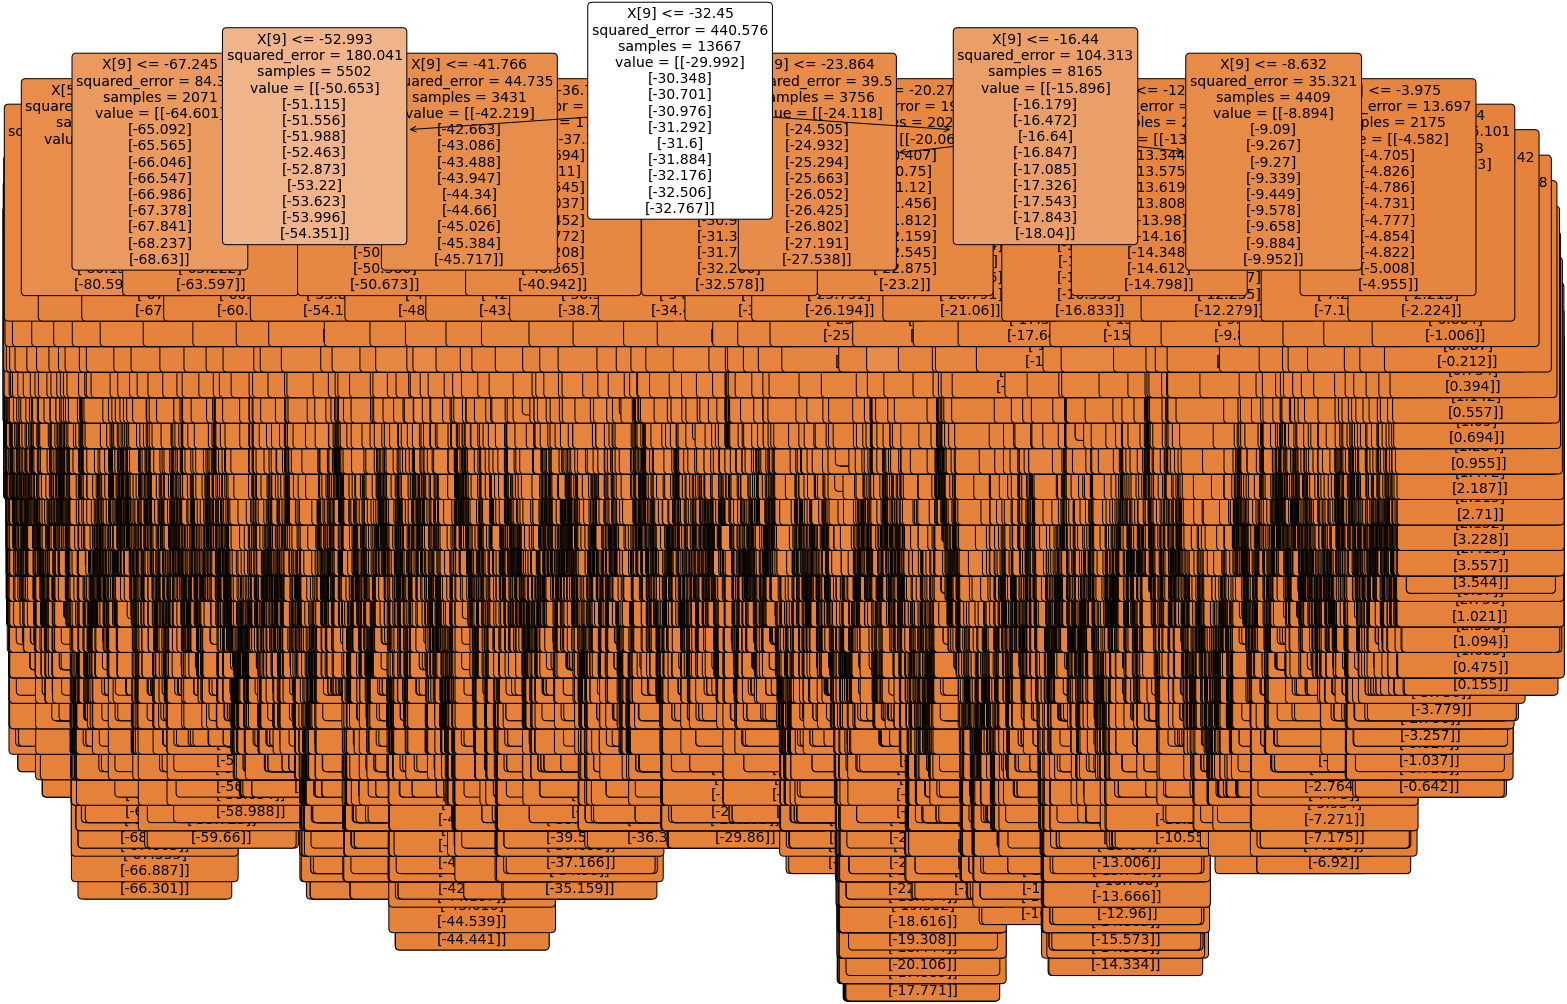

In [86]:
from sklearn import tree
Tree = model.estimators_[5]
plt.figure(figsize=(25,15))
tree.plot_tree(Tree,filled=True, 
              rounded=True, 
              fontsize=14);

Scores:Return the coefficient of determination of the prediction. R^2

In [81]:
scores

[0.967981643309105,
 0.9696091306254623,
 0.9700009942569645,
 0.9704131867747762,
 0.9706561029594158,
 0.9707764067048347,
 0.9708797136566479,
 0.9709303711466042,
 0.9709919460945061,
 0.9710554366696822,
 0.9710789251837134,
 0.9711241885645551,
 0.97116478247141,
 0.9711993815071134,
 0.9712085611154742,
 0.9712099924821693,
 0.9712114032497787,
 0.9712297067524132,
 0.9712252071441416]

##### Train model

##### Step 4 - Plot loss over epochs

In [82]:
# Predicting the target values of the test set
Y_pred = model.predict(X_test)

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(Y_test, Y_pred)), '.3f'))
print("\nRMSE: ", rmse)
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))



RMSE:  2.491
Mean Absolute Error: 1.8669493560398576
Mean Squared Error: 6.206921437345663
Root Mean Squared Error: 2.4913693899832805


In [83]:
# Calculate the absolute errors
errors = abs(Y_pred - Y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / Y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 1.87 degrees.
Accuracy: 111.47 %.


c:\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

c:\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



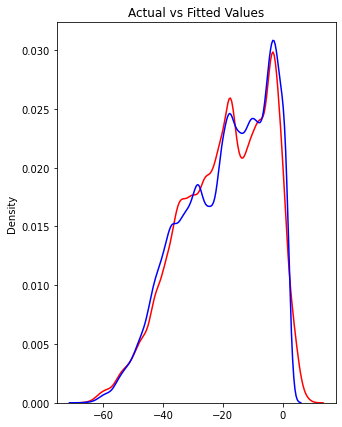

In [85]:
import seaborn as sns
plt.figure(figsize=(5, 7))


ax = sns.distplot(Y_test, hist=False, color="r", label="Actual Value")
sns.distplot(Y_pred, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

In [ ]:
##### Step 5 - Print Performance Summary